# Heart Disease Classification

## Introduction:

Heart disease is a prevalent health risk and one of the single largest causes of death in the world. Understanding how certain health factors affect the diagnosis of heart disease is important for understanding how to prevent heart disease. This data set (processed Cleveland data) includes observations of the age, sex, and results of many medical tests for people with and without heart disease.

The predictor variables we are interested in for this project are:

age - age of the patient in years

chol - serum cholesterol of the patient in mg/dl

thalach - maximum heart rate achieved in bpm

oldpeak - ST depression induced by exercise relative to rest

ca - number of major vessels (0-3) coloured by flourosopy

The target variable we are interested in predicting is “num”. This dataset only concentrates on whether heart disease is present (values 1,2,3,4) or absent (value 0). Therefore, we have coded all non zero values as a positive diagnosis and zero as a negative diagnosis for heart disease. This data set includes 297 entries in total.

**Research question: Based on the age, chol, thalach, oldpeak, and ca variables for a patient, can we accurately predict whether or not they will receive a heart disease diagnosis.**


**Method**

We will make a k-nn classification model to predict whether or not a person will have a diagnosis of heart 
disease based on these predictor variables: age, chol, thalach, oldpeak, and ca. We will tune our classifier by
cross-validating our data to determine the K-value that will give us the best accuracy, then make a new
classification model using this K-value.

We will visualize the results by making scatterplots/barplots for different variables to observe the effect of their values on our response variable: the heart disease diagnosis.


**What do you expect to find?**

We want to find which variables will cause the diagnosis of heart disease. We expect that older age, higher cholesterol, higher ST depression induced by exercise, higher number of major vessels coloured by fluoroscopy, and lower maximum heart rate achieved will be correlated with a diagnosis of heart disease. We hope to make an accurate enough model to diagnose patients based on their medical information.

**What impact could such findings have?**

Our model will help us identify which patients are predicted to be having heart disease. Using this information, we can identify patients who needs immediate medical attention to prevent potentially life threatening situations like a heart attack from occurring. Preventive measures can be performed by a doctor upon this predictive diagnosis. This could possibly save a patient's life. 

**What future questions could this lead to?**

- What are the specific clinical scenarios or patient populations for which the model is most beneficial?
- Why is a certain variable correlated with a positive heart disease diagnosis? 
- How can we use these findings to prevent heart disease?
- How can we use data analysis to predict those who are at risk for heart disease?
- How can the quality and quantity of data used for model development be improved to enhance prediction accuracy?

In [ ]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
install.packages("kknn")
install.packages("cowplot")
library(cowplot)
library(kknn)

In [ ]:
set.seed(9999)

We set a seed to make our results reproducible and loaded the necessary packages to be able to do our data analysis.

In [ ]:
# Loaded data set and omitted N/A values

url <- "https://archive.ics.uci.edu/static/public/45/data.csv"
heart <-  read_csv(url)
heart <- na.omit(heart)
head(heart)

In [ ]:
# In the Cleveland dataset, any occurance of "num" other than 0 is considered a presence of heart disease

heart$num <- ifelse(heart$num >= 1 & heart$num <= 4, "yes", "no")

# Making num a factor variable

heart <- heart |>
        mutate(num = as_factor(num))
head(heart)

**Here, we have changed all non-zero values of num to "yes", and 0 values to "no". This is done because our data set is only focused on the presence or absence of heart disease, not the severity of it. We have also changed the num variable into a factor so we can perform classification on it.**

In [ ]:
# Separating data into training and testing sets

heart_split <- initial_split(heart, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [ ]:
# Seeing number of occurances of each class of our target variable "num"

distribution <- heart_training |>
                group_by(num) |>
                summarize(count = n())

print("Table: Distribution of Positive and Negative Diagnosis In Training Data")
distribution

**The above table shows us the proportion of positive and negative heart disease diagnoses present in our training data. About 54% individuals in the training data do not have heart disease and 46% have heart disease.  Since the two catagories are approximately equal, we can do classification model using k-nearest neighbors. This is because no one catagory is going to influence the catagory of majority of nearest neighbors.**

In [50]:
# Making a table of means of each predictor, based on diagnosis

mean_chol <- heart_training |>
            group_by(num) |>
            summarize(chol = mean(chol))
mean_age <- heart_training |>
            group_by(num) |>
            summarize(age = mean(age))
mean_thalach <- heart_training |>
                group_by(num) |>
                summarize(thalach = mean(thalach))
mean_oldpeak <- heart_training |>
                group_by(num) |>
                summarize(oldpeak = mean(oldpeak))
mean_ca <- heart_training |>
                group_by(num) |>
                summarize(ca = mean(ca))

print("Average predictor value with and without heart disease diagnosis")
combined_means <- bind_rows(mean_chol, mean_age, mean_thalach, mean_oldpeak, mean_ca) |>
                    pivot_longer(cols = chol:ca,
                                names_to = "predictor_name",
                                values_to = "predictor_mean") |>
                    na.omit() |>
                    rename("heart_disease" = "num")
combined_means


[1] "Average predictor value with and without heart disease diagnosis"


heart_disease,predictor_name,predictor_mean
<fct>,<chr>,<dbl>
no,chol,242.9250000
yes,chol,254.0686275
no,age,52.2166667
yes,age,57.6372549
no,thalach,158.0750000
yes,thalach,138.8627451
no,oldpeak,0.6233333
yes,oldpeak,1.7058824
no,ca,0.3166667


**For each predictor variable, we plotted the mean value for patients with heart disease and those without. Based on the bar graphs for each variable, we can see that the mean values differ between those with heart disease and those without. Because of this, we used these variables in our classification model.**

In [ ]:
# Graphing the table above to compare diagnosis/no diagnosis averages for each predictor

options(repr.plot.width = 8, repr.plot.height = 10)

chol_avg <- combined_means |>
filter(predictor_name == "chol")

chol_var <- chol_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average cholesterol",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average cholesterol of\nindividuals with and\nwithout heart disease")



age_avg <- combined_means |>
filter(predictor_name == "age")

age_var <- age_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average age",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average age of individuals\nwith and without heart\ndisease")



thalach_avg <- combined_means |>
filter(predictor_name == "thalach")

thalach_var <- thalach_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average max heart rate (bpm)",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average max heart rate of\nindividuals with and without\nheart disease")



oldpeak_avg <- combined_means |>
filter(predictor_name == "oldpeak")

oldpeak_var <- thalach_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average ST depression",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average ST depression\ninduced by exercise of\nindividuals with and without\nheart disease")



ca_avg <- combined_means |>
filter(predictor_name == "ca")

ca_var <- ca_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average number of vessels",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average number of vessels\ncoloured by fluoroscopy of\nindividuals with and without\nheart disease")


plot_grid(chol_var, age_var, thalach_var, oldpeak_var, ca_var, nrows = 3)

**For each predictor variable, we plotted the mean value for patients with heart disease and those without. Based on the bar graphs for each variable, we can see that the mean values differ between those with heart disease and those without. Because of this, we used these variables in our classification model.**

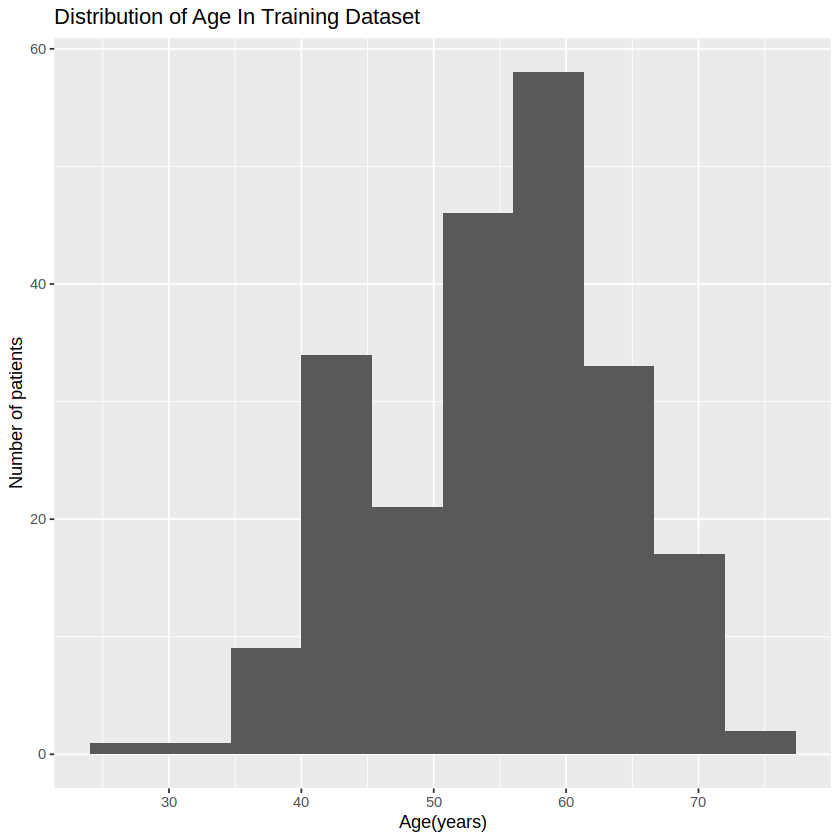

In [53]:
agedistribution <- heart_training |>
ggplot(aes(x = age)) +
geom_histogram(bins = 10) +
labs(x = "Age(years)", y = "Number of patients") +
ggtitle("Distribution of Age In Training Dataset")
agedistribution

**The age of the individuals in this data set range from ~20 to ~80 years old, with the average age of people being around 55 years old. The distribution is symmetrical and resembles a bell curve.**


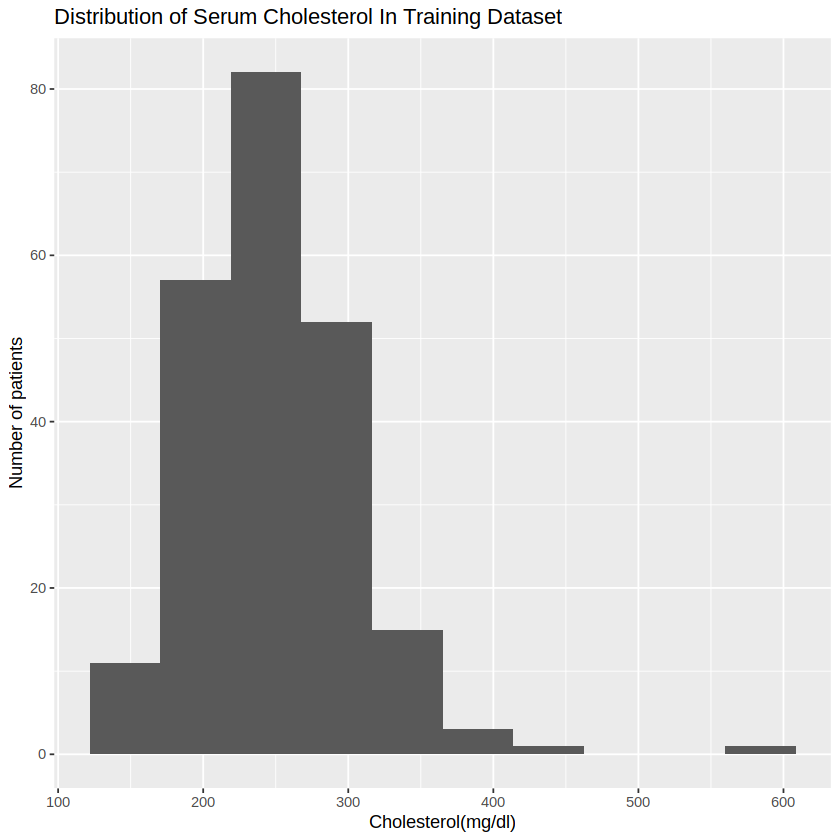

In [54]:
choldistribution <- heart_training |>
ggplot(aes(x = chol)) +
geom_histogram(bins = 10) +
labs(x = "Cholesterol(mg/dl)", y = "Number of patients") +
ggtitle("Distribution of Serum Cholesterol In Training Dataset")
choldistribution

**The cholesterol levels range from ~100 mg/dl to ~600 mg/dl, with the average around 250 mg/dl. 
The cholesterol levels range from ~100 mg/dl to ~600 mg/dl, with the average around 250 mg/dl. The distribution is skewed to the left, with a small number of people having over 400 mg/dl cholesterol levels.**


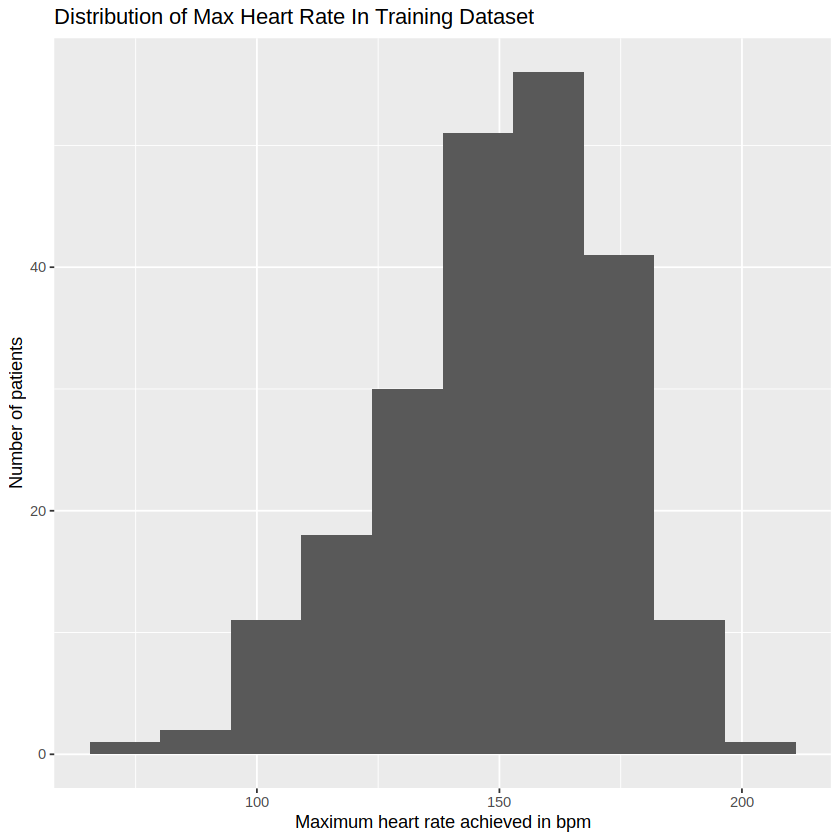

In [55]:
thalachdistribution <- heart_training |>
ggplot(aes(x = thalach)) +
geom_histogram(bins = 10) +
labs(x = "Maximum heart rate achieved in bpm", y = "Number of patients") +
ggtitle("Distribution of Max Heart Rate In Training Dataset")
thalachdistribution


**The maximum heart rate ranges from ~50 bpm to ~250 bpm, with the average at around 160 bpm. The distribution is skewed slightly to the right, suggesting our testing data contains more individuals with higher maximum heart rates.**


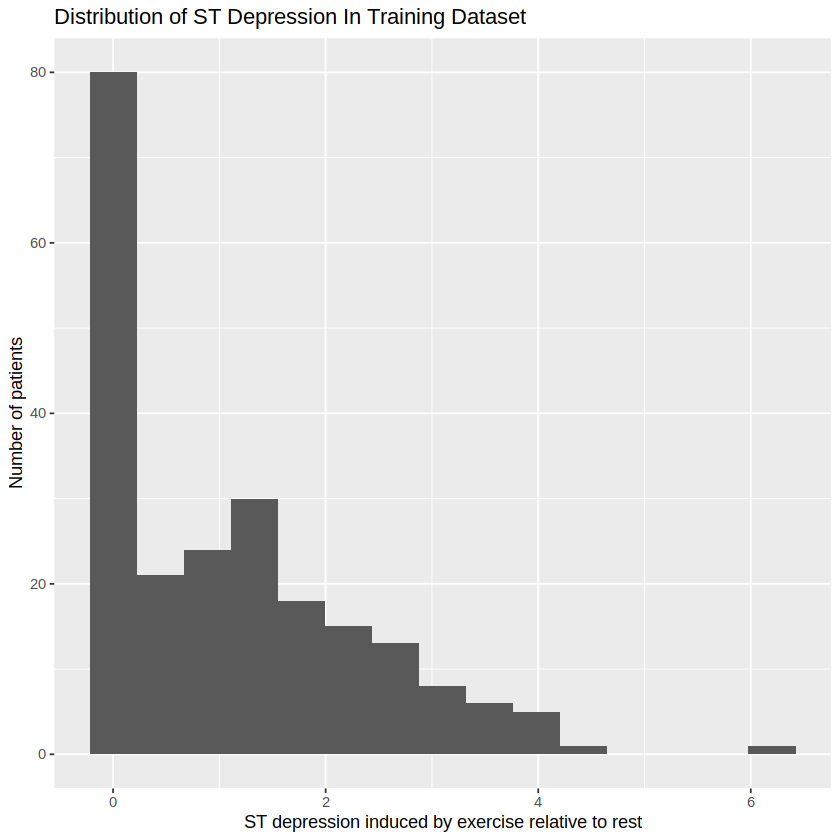

In [56]:
oldpeakdistribution <- heart_training |>
ggplot(aes(x = oldpeak)) +
geom_histogram(bins = 15) +
labs(x = "ST depression induced by exercise relative to rest", y = "Number of patients") +
ggtitle("Distribution of ST Depression In Training Dataset")
oldpeakdistribution


**The ST depression induced by exercise relative to rest ranges from 0 to ~6, with the average around one. The distribution is skewed to the left, with the most amount of people having a ST depression of ~0, and the least amount of people having an ST depression of ~6.**


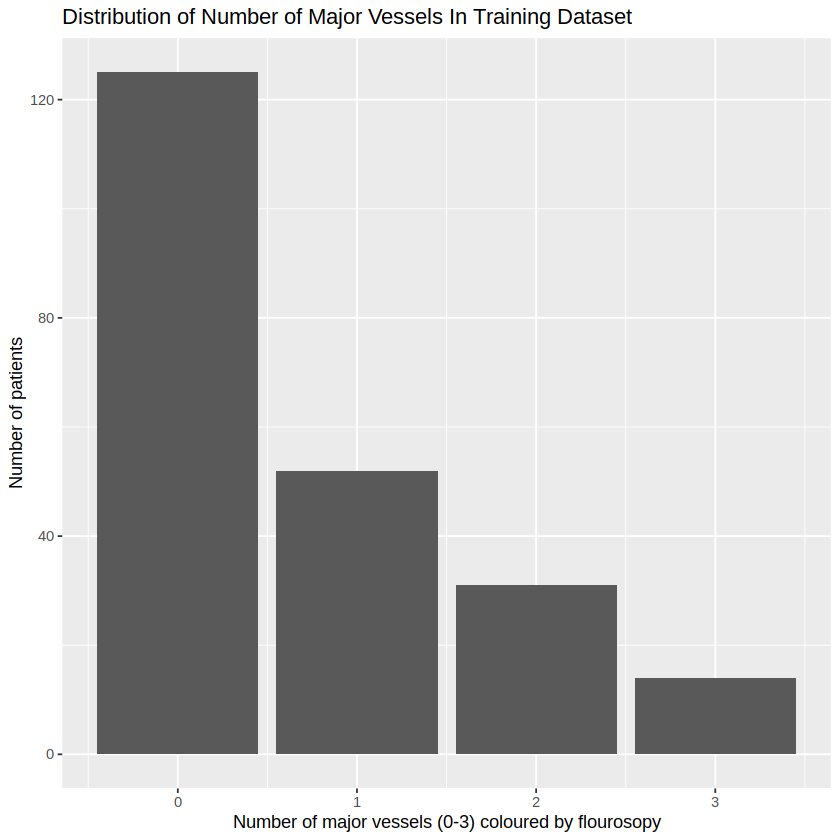

In [57]:
cadistribution <- heart_training |>
ggplot(aes(x = ca)) +
geom_bar() +
labs(x = "Number of major vessels (0-3) coloured by flourosopy", y = "Number of patients") +
ggtitle("Distribution of Number of Major Vessels In Training Dataset")
cadistribution

**The distribution of the amount of vessels coloured by fluoroscopy of individuals in this database ranges from 0 to 3, the distribution is skewed to the left, with the most amount of people having 0 coloured vessels, and the least amount of people having 3 coloured vessels.**


In [58]:
# created a range of values for k
k_vals <- tibble(neighbors = seq(1, 100, 5))

In [19]:
# created a vfold of 5 folds
heart_vfold <- vfold_cv(heart_training, v = 5, strata = num)

In [20]:
# created model for tuning
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# created recipe using subtrain data
heart_recipe <- recipe(num ~ age + chol + thalach + oldpeak + ca,
                 data = heart_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

In [21]:
# combined the model and recipe into a workflow and fit with subtrain data
cv_workflow <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(tune_spec) |>
                tune_grid(resamples = heart_vfold, grid = k_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

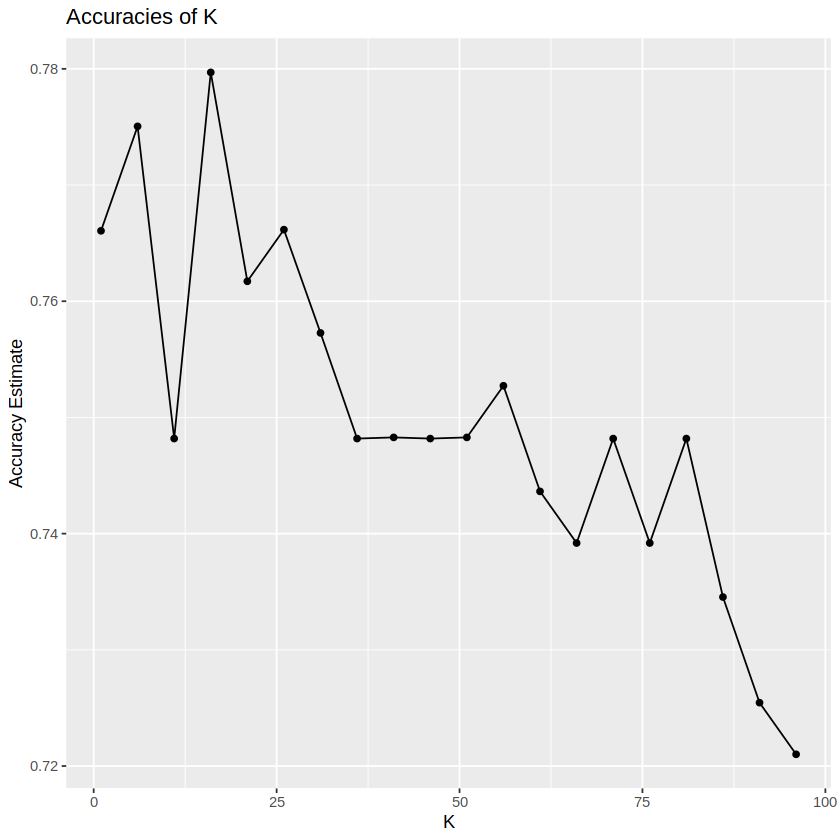

In [22]:
# Graphing the k-values with their accuracy
k_vals_accuracy_plot <- cv_workflow |>
                        ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "K", y = "Accuracy Estimate") +
                        ggtitle("Accuracies of K")
k_vals_accuracy_plot


**This graph tells us what the accuracy of k values ranging from 1 - 100, incrementing by 5. According to the graph above, the highest accuracy seems to be 14. We can extract the exact value that represents the peak in the graph above using the code below:**

In [23]:
# choosing the best k-value based on accuracy

best_k <- cv_workflow |>
            slice_max(mean) |>
            pull(neighbors)
best_k

[1] 16

**Now with a k = 16, we make a final model. The accuracy of this new model will be tested using the testing data.**

In [24]:
# After choosing the best k-value for our model, we make a model using that k value

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_engine("kknn") |>
            set_mode("classification")

In [27]:
# we fit our new model to the heart training data using a workflow

new_fit <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(knn_spec) |>
                fit(heart_training) 

In [28]:
# we check this model's accuracy using our testing dataset

heart_disease_predictions <- predict(new_fit, heart_testing) |>
                            bind_cols(heart_testing)
head(heart_disease_predictions)

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,67,1,4,160,286,0,2,108,1,1.5,2,3,3,yes
no,57,0,4,120,354,0,0,163,1,0.6,1,0,3,no
yes,63,1,4,130,254,0,2,147,0,1.4,2,1,7,yes
no,44,1,2,120,263,0,0,173,0,0.0,1,0,7,no
no,52,1,3,172,199,1,0,162,0,0.5,1,0,7,no
no,57,1,3,150,168,0,0,174,0,1.6,1,0,3,no


**This table represents the predicted diagnosis for each patient in the ".pred_class" column and the actual diagnosis of the patient in the "num" column. In the first 6 rows of this table, we can see that all predictions were actually correct. Let us check the accuracy of the predictions for the whole table using the code below:**

In [29]:
# Testing our final model accuracy using our testing data
model_accuracy <- heart_disease_predictions |>
                    metrics(truth = num, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
model_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333


**Our model had an accuracy of 73% when tested on the testing data. This is not particularly bad but also not particularly good when we consider the way we will be using our model. The cost of misdiagnosing someone with heart disease is high. Perhaps this is not a useful model to use in the real world.**

In [30]:
# Confusion matrix

confusion <- heart_disease_predictions |>
            conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction no yes
       no  36  16
       yes  4  19

# Conclusion: 

The confusion matrix above gives us more insight about the usefulness of our model than the accuracy measured above. Our positive result is a "yes" diagnosis (indicating the presence of heart disease), while our negative result is a "no" diagnosis (indicating an absence of heart disease). The confusion matrix tells us that our model has a precision of 19/23 ~ 82.6%. On the other hand, it has a recall of 19/35 ~ 54.29%. This is not good! This suggests that given a patient has heart disease, our model is only able to predict this about 54.29% of the time! We can therefore conclude that this model is not safe to use in a real-world scenario. The inability to diagnose a heart disease patient could prove fatal since an accurate and timely diagnosis is needed to prevent a heart attack.  

### Possible Reasons For Low Model Accuracy & Future Improvements:

Possible reasons for why we couldn't create a useful model could include our small dataset size. We only had 297 data entries in total, and only 75% of that was used for training our model. This appears to not have been enough to train the model properly. 

Another reason could have been that the wrong predictor variables were chosen. Perhaps using more/less/different variables could have yielded a better model. 

To summarize, this model is not useful since its recall is quite low. This low recall value is highly dangerous in the real world since we don't want to be misdiagnosing patients who have heart disease as this can be fatal. However, our exploratory analysis and research suggested that older age, higher cholesterol, higher ST depression induced by exercise, higher number of major vessels coloured by fluoroscopy, and lower maximum heart rate achieved were all correlated with the presence of heart disease.